In [3]:
!pip install python-dotenv
!pip install --upgrade pip
!pip install --upgrade pip
!pip install --upgrade pip

In [45]:
import base64
import requests
import datetime
from urllib.parse import urlencode
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo
import scipy.stats as stats
import seaborn as sns
from matplotlib.pyplot import figure
import plotly 
import plotly.express as px
from scipy.stats import norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from math import pi
%matplotlib inline

In [6]:
# Upload dataset and set client_id/client_secret 
client_id = ###
client_secret = ###

df = pd.read_csv("audd_music_spotify_music.csv")

In [7]:
#Spotify client with track/album/artist query functions
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')
    
    def get_track_info_by_id(self, _id):
        ### Retrieve track information with track ID
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/tracks"
        lookup_url = f"{endpoint}/{_id}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    
    def query_track_audio_features(self, _id):
        # Use the Spotify API call to retreive audio features (danceability, tempo, mode, etc.) from the track id
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/audio-features"
        lookup_url = f"{endpoint}/{_id}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
     
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()
    
    def search(self, query=None, operator=None, operator_query=None, search_type='artist' ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower()})
        return self.base_search(query_params)

In [8]:
spotify = SpotifyAPI(client_id, client_secret)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df = df[df['id'].notna()]

In [11]:
# Drop unneccessary columns
df.drop(['album.album_group', 'album.release_date_precision', 'album.available_markets', 'linked_from', 'external_ids.isrc', 'external_urls.spotify', "available_markets", "disc_number"], axis=1, inplace=True)

In [12]:
df = df.reset_index(drop=True)

In [13]:
## Now we will use our track ids and our query_track_audio_features function to retrieve our audio features and add them to the dataframe.
df["audio_features"] = df["id"].apply(spotify.query_track_audio_features)

In [15]:
## We can see that each item in audio feature is a dictionary. We can turn this into a dataframe and then concatenate it to the original dataset. 
audio_features_df = pd.DataFrame(list(df["audio_features"]))
df = pd.concat([df, audio_features_df], axis=1)
df = df.loc[:,~df.columns.duplicated()]

In [16]:
### The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist’s popularity is calculated from the popularity of all the artist’s tracks.

### Does previous popularity have any effect on how well it would do on tiktok? were all the songs already popular? What's the average popularity of trending songs
popularity_sorted_df = df.sort_values('popularity', ascending = False)
popularity = popularity_sorted_df['popularity']


177             Mood (feat. iann dior)
192                       The Business
7                          WITHOUT YOU
104                            BICHOTA
202                          positions
78                               34+35
76                      Therefore I Am
18             What You Know Bout Love
275    WAP (feat. Megan Thee Stallion)
220                         Goosebumps
Name: name, dtype: object

In [17]:
popularity_sorted_df['name'].tail(10)

307                      Rebel
276             La vie en rose
284                Finish Line
81                         Sad
79               Royal Cookies
73                      Heroin
171                 XGamesMode
315                All At Once
292    مهرجان ادينى الولا محسن
338                     Inborn
Name: name, dtype: object

In [18]:
popularity.mean()

48.666666666666664

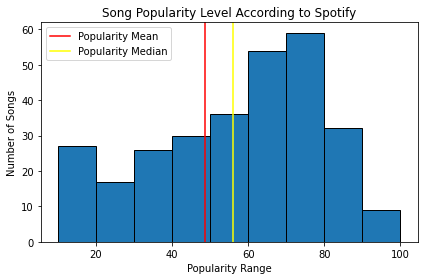

In [19]:
mean_popularity = popularity.mean() # ---> 53.01
median_popularity = popularity.median() # ---> 61.0
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.hist(popularity, bins=bins, edgecolor="black")
plt.title("Song Popularity Level According to Spotify")
plt.xlabel("Popularity Range")
plt.ylabel("Number of Songs")
plt.axvline(mean_popularity, color='red', label="Popularity Mean")
plt.axvline(median_popularity, color='yellow', label="Popularity Median")
plt.tight_layout()
plt.legend()

**Energy — The energy of a song, the higher the value, the more energetic.<br>
Danceability — The higher the value, the easier it is to dance to this song.<br>
Loudness — The higher the value, the louder the song (in dB).<br>
Valence — The higher the value, the more positive mood for the song.<br>
Length — The duration of the song.<br>
Acousticness — The higher the value the more acoustic the song is.<br>
Release Year — The year each song was released.<br>
Popularity — The higher the value the more popular the song is.<br>**

In [20]:
audio_names = ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']

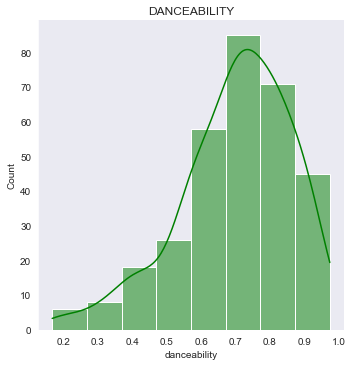

In [34]:
sns.set_style('dark')
sns.displot(df.danceability, kde=True, bins=8, color='green').set(title='DANCEABILITY')

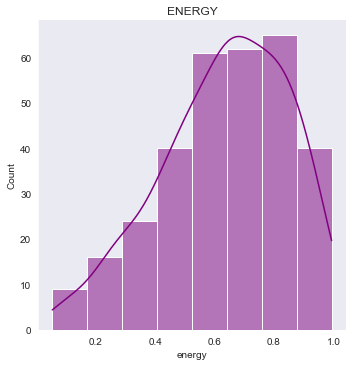

In [36]:
sns.displot(df.energy, kde=True, bins=8, color='purple').set(title='ENERGY')

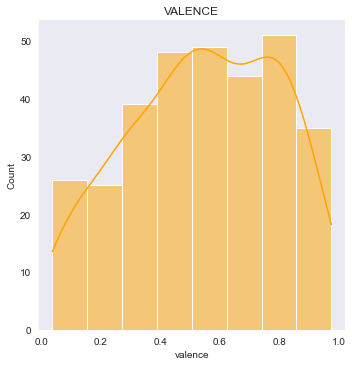

In [37]:
sns.displot(df.valence, kde=True, bins=8, color='orange').set(title='VALENCE')

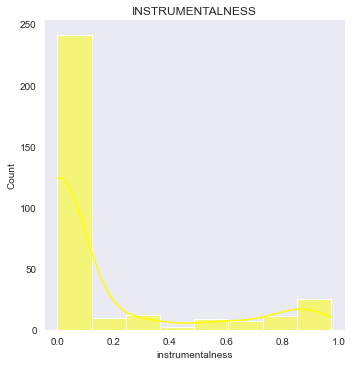

In [38]:
sns.displot(df.instrumentalness, kde=True, bins=8, color='yellow').set(title='INSTRUMENTALNESS')

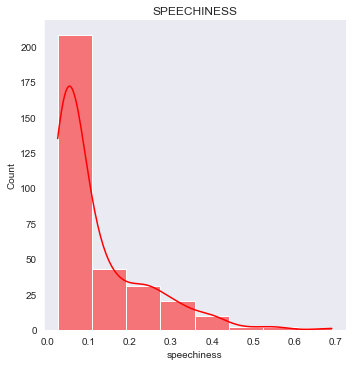

In [39]:
sns.displot(df.speechiness, kde=True, bins=8, color='red').set(title='SPEECHINESS')

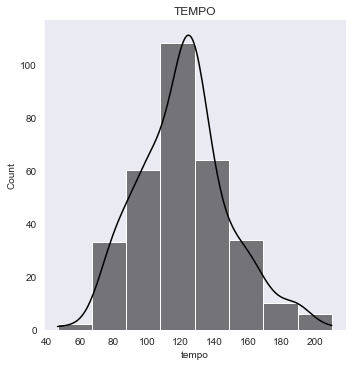

In [40]:
sns.displot(df.tempo, kde=True, bins=8, color='black').set(title='TEMPO')

## Release Year

In [28]:
df['release_year'] = pd.DatetimeIndex(df["album.release_date"]).year
release_years = df['release_year']

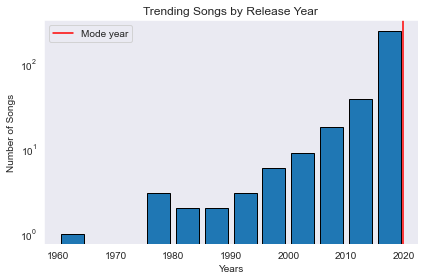

In [29]:
mode_year = release_years.mode()
bins = [1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]
x_min = 1969
x_max = 2020
mode_year = int(release_years.mode()) 
plt.hist(df['release_year'], bins=bins, edgecolor="black", rwidth=.8, log=True)
plt.axvline(mode_year, color='red', label="Mode year")
plt.title("Trending Songs by Release Year")
plt.xlabel("Years")
plt.ylabel("Number of Songs")
plt.tight_layout()
plt.legend()

## Radar Chart

In [42]:
audio_features_radar_chart = audio_features_df[['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       ]]

In [43]:
audio_features_radar_chart

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.772,0.878,-4.220,0.3240,0.03010,0.000002,0.2510,0.3050,61.311,135747.0
1,0.871,0.725,-9.506,0.0777,0.23800,0.053800,0.3260,0.7450,128.980,156360.0
2,0.578,0.600,-5.700,0.0455,0.14400,0.000000,0.4260,0.6460,76.999,277307.0
3,0.726,0.780,-6.312,0.0414,0.13700,0.914000,0.0985,0.0742,119.991,242016.0
4,0.653,0.667,-6.764,0.0423,0.15400,0.000000,0.1070,0.5560,104.181,213869.0
...,...,...,...,...,...,...,...,...,...,...
334,0.673,0.526,-13.460,0.0322,0.73800,0.856000,0.0798,0.8370,145.250,173824.0
335,0.903,0.545,-6.896,0.0500,0.02260,0.000008,0.0571,0.8700,124.011,188987.0
336,0.380,0.292,-14.282,0.0540,0.49800,0.026200,0.1260,0.0777,75.572,194400.0
337,0.672,0.855,-3.764,0.0397,0.02100,0.000000,0.3230,0.6460,123.056,182200.0


In [44]:
min_max_scaler = MinMaxScaler()
audio_features_radar_chart.loc[:]=min_max_scaler.fit_transform(audio_features_radar_chart.loc[:])

/Users/wesleyhouse/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/wesleyhouse/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



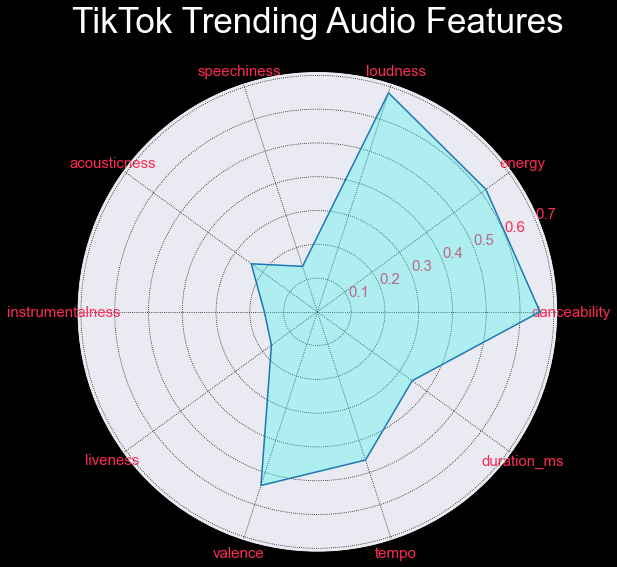

In [46]:
# Plot the size and set the colors of the graph
fig=plt.figure(figsize=(12,8), facecolor="black", edgecolor="black")

# convert audio feature names into a list
categories=list(audio_features_radar_chart.columns)
# Store their count in a variable
N=len(categories)

# Establish a list of averages for each audio feature
value=list(audio_features_radar_chart.mean())

# Since the plot will essentially be a closed circile, we will need to repeat the first item
# And then we'll append that first item back to the list to close the circle.
value+=value[:1]
# Calculating the angle for each category
angles=[n/float(N)*2*pi for n in range(N)]
angles+=angles[:1]

# Plot the radar chart with respective angles. Add colors and design. 
plt.polar(angles, value)
plt.fill(angles,value,alpha=0.3, color="#25F4EE")
plt.grid(True,color='k',linestyle=':')


# markeredgecolor or mec: color

plt.title('TikTok Trending Audio Features', size=35, color="white", pad=40)
plt.xticks(angles[:-1],categories, size=15)
plt.xticks(color='#FE2C55',size=15)
plt.yticks(color='#FE2C55',size=15)
plt.tight_layout()
plt.show()